In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data, test, train, movies = pd.read_csv("data/data.csv"), pd.read_csv("data/test.csv"), pd.read_csv("data/train.csv"), pd.read_csv("data/movies.csv")


Let m, n be the number of users and movies, respectively, and Y be the m by n matrix of the movie ratings, where y_ij corresponds to user i's rating for the movie j. 

In [3]:
Y = [[row["User ID"], row["Movie ID"], row["Rating"]] for idx, row in data.iterrows()]

In [4]:
N_TRAIN = 90000
Y_train = np.array(Y[:N_TRAIN])
Y_test = np.array(Y[N_TRAIN:])

In [5]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    g = reg*Ui - (Vj * (Yij - Ui.T @ Vj))
    return eta * g


def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    g = reg*Vj - (Ui * (Yij - Ui.T @ Vj))
    return eta * g


def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    normfactor = reg * np.linalg.norm(U, ord='fro')**2 + np.linalg.norm(V, ord='fro')**2
    errfactor = 0 
    pred = U @ V.T
    for i1,j1,Yij in Y:
        i,j = i1-1, j1-1
        errfactor += (Yij - pred[i][j]) ** 2
    return (normfactor + errfactor) / (2 * len(Y))
    

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.uniform(-0.5,0.5,(M, K))
    V = np.random.uniform(-0.5,0.5,(N, K))
    last_err = get_err(U,V,Y,reg=reg)
    
    first_de = None
    for epoch in tqdm(range(max_epochs)):
        np.random.shuffle(Y)
        U, V = np.copy(U), np.copy(V)
        
        for i1,j1,Yij in Y:
            i,j = i1-1, j1-1
            U[i] -= grad_U(U[i], Yij, V[j], reg, eta)
            V[j] -= grad_V(V[j], Yij, U[i], reg, eta)
            
        err = get_err(U,V,Y,reg=reg)
        de = err - last_err
        
        if first_de is None:
            first_de = de
        elif de/first_de <= eps:
            return U, V, err
        
        last_err = err
        
    return U, V, get_err(U,V,Y,reg=reg)
    

In [6]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
k = 20

regs = [10**-4, 10**-3, 10**-2, 10**-1, 1]
eta = 0.03 # learning rate
E_ins = []
E_outs = []

# Use to compute Ein and Eout
for reg in regs:
    E_ins_for_lambda = []
    E_outs_for_lambda = []

    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, k, eta, reg))
    U,V, e_in = train_model(M, N, k, eta, reg, Y_train)
    E_ins_for_lambda.append(e_in)
    eout = get_err(U, V, Y_test)
    E_outs_for_lambda.append(eout)

    E_ins.append(E_ins_for_lambda)
    E_outs.append(E_outs_for_lambda)



Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.0001


  3%|▎         | 9/300 [00:21<11:31,  2.38s/it]


Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.001


  4%|▎         | 11/300 [00:24<10:53,  2.26s/it]


Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.01


  6%|▋         | 19/300 [00:40<10:00,  2.14s/it]


Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.1


  6%|▌         | 18/300 [00:39<10:18,  2.19s/it]


Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 1


  2%|▏         | 6/300 [00:15<12:37,  2.58s/it]


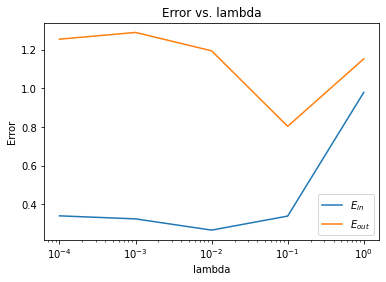

In [15]:

# Plot values of E_in across k for each value of lambda

plt.plot(regs, E_ins, label="$E_{in}$")
plt.plot(regs, E_outs, label="$E_{out}$")
plt.title('Error vs. lambda')
plt.xlabel('lambda')
plt.ylabel('Error')
plt.legend()
# plt.savefig('2e_ein.png')
# plt.clf()
plt.xscale('log')
plt.show()


Best U,V with lambda = 1/10. 

In [17]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
k = 20

reg = 10**-1
eta = 0.03 # learning rate

U,V, e_in = train_model(M, N, k, eta, reg, Y_train)


  6%|▋         | 19/300 [00:44<11:01,  2.36s/it]


In [27]:
np.save('method1_U.npy', U.T)
np.save('method1_V.npy', V.T)